# 数值分析 实验一
计63 陈晟祺 2016010981

## 上机题1

### 实验概要
本题要求实现例 1.4，即分析一阶导数的差商近似带来的误差。我们知道，当步长为 $h$ 时，总误差限为：
$$
\varepsilon_{tot} = \frac{Mh}{2} + \frac{2\varepsilon}{h}
$$
前一项随着 $h$ 减小而减小，后一项则相反，当 $h=2\sqrt{\varepsilon/M}$ 时总计算误差最小。其中的 $M$ 为 $|f''(\varepsilon)|$ 的上界，而 $\varepsilon$ 为双精度浮点数的机器精度。

当 $f(x)=\sin(x)$，在 $x=1$ 点用差商计算导数。取 $M=1$ 和 $\varepsilon \approx 10^{-16}$，绘制 $\varepsilon_{tot}$ 随 $h$ 的变化关系。

### 实验过程

首先导入必要的库和声明常数

In [1]:
import numpy as np
import matplotlib.pyplot as plt

M = 1
eps = 1e-16

定义不同的误差计算函数

In [2]:
def truncate_error(h):
    return M * h / 2

def round_error(h):
    return 2 * eps / h

def total_error(h):
    return truncate_error(h) + round_error(h)

def actual_error(h):
    approx = (np.sin(1 + h) - np.sin(1)) / h
    return np.abs(approx - np.cos(1))

定义绘图区间并计算误差：

In [3]:
x = [10 ** (-16.0 + i * 0.5) for i in range(33)]

In [4]:
t_errors = list(map(truncate_error, x))
r_errors = list(map(round_error, x))
tot_errors = list(map(total_error, x))
act_errors = list(map(actual_error, x))

绘制误差图象：

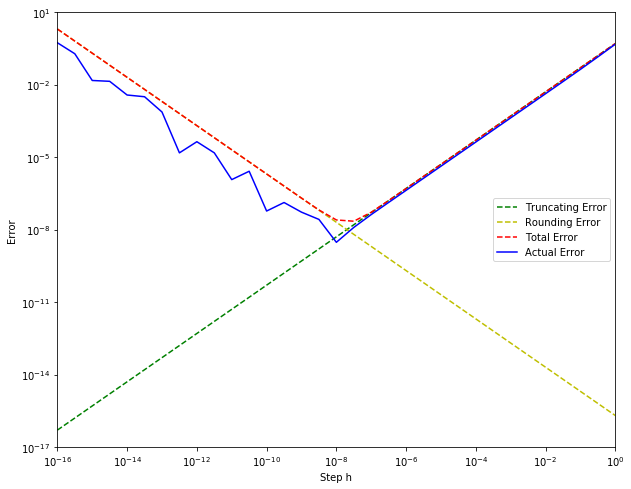

In [5]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set_xscale("log", nonposx='clip')
ax.set_xlim((1e-16,1e0))
ax.set_xlabel('Step h')
ax.set_yscale("log", nonposy='clip')
ax.set_ylim((1e-17,1e1))
ax.set_ylabel('Error')
plt.plot(x, t_errors, 'g--', label='Truncating Error')
plt.plot(x, r_errors, 'y--', label='Rounding Error')
plt.plot(x, tot_errors, 'r--', label='Total Error')
plt.plot(x, act_errors, 'b', label='Actual Error')
plt.legend()
plt.show()

### 实验结论

上图与例 1.4 的图象吻合得很好，可以看到 $h=h_0=10^{-8}$ 时，实际误差的确是最小的；而离这一最优步长越远，误差就越大。由此可知，例 1.4 给出了一种比较精确的差商近似导数的误差估计方法。在实际中使用差商法时，我们应该选取这一使误差最小的步长值，以得到更精确的结果。

## 上机题3

### 实验概要

本次要求使用单精度浮点数计算调和级数并在值不再变化时记录 $n$，将其与理论分析的结论进行比较。然后使用双精度浮点数评估单精度浮点数计算结果的误差，并估计当 n 为何值时不再发生变化。

### 实验过程

首先找到使单精度计算结果不再变化的 $n$ 值，并进行验证

In [6]:
n = 1
sum = np.float32(0)

while True:
    new_sum = np.float32(sum + 1 / np.float32(n))
    if new_sum == sum:
        break
    n += 1
    sum = new_sum
    
print('Summation stops at {} with n = {}'.format(sum, n))

Summation stops at 15.403682708740234 with n = 2097152


In [7]:
sum == np.float32(sum + 1 / np.float32(n + 1))

True

根据理论分析，我们可以知道，当
$$
\frac{1}{n} \le \frac{1}{2} \varepsilon_{\text{mach}} \sum_{k=1}^{n-1}\frac{1}{k}
$$
时，结果值将停止变化。我们可以计算得到这一 $n$ 值：

In [8]:
n = 1
sum = 0
eps = 6e-8

while True:
    n_rec = 1 / np.float64(n)
    if n_rec <= eps * sum / 2:
        break
    sum += n_rec
    n += 1
    
print(n)

2195967


可以看到理论值比估计值略大，这是由于机器精度是近似值，并且在这一计算过程中也产生了截断误差导致的。

使用双精度浮点数再次计算值，并比较误差：

In [9]:
n = 1
sum_32 = 0
sum_64 = 0

while n <= 2097152:
    sum_64 += 1 / np.float64(n)
    sum_32 = np.float32(sum_32 + 1 / np.float32(n))
    n += 1

dif_abs = np.abs(sum_64 - sum_32)
dif_rel = dif_abs / sum_64

print('Absolute error: {:.3f}, relative error: {:.3%}'.format(dif_abs, dif_rel))

Absolute error: 0.270, relative error: 1.787%


如果使用双精度浮点数进行计算，可以估算停止时的 $n$。调和级数此时可以近似为 $\ln n + \gamma + \frac{1}{2n}$，其中 $\gamma$ 为欧拉常数。则不等式转化为：
$$
\frac{1}{n} \le \frac{1}{2} \varepsilon_{\text{mach}} (\ln n + \gamma + \frac{1}{2n})
$$

使用 SciPy 对上面的方程进行数值求解：

In [10]:
from scipy.optimize import fsolve

def stop(n):
    eps = 1e-16
    gamma = 0.57721566490153286060651209008240243104215933593992
    return eps * (np.log(n) + gamma + 1 / (2 * n)) / 2 - 1 / n

r = fsolve(stop, [1.])
print(r)

[  5.78556829e+14]


使用 Linpack 测试可知我计算机的浮点性能峰值大约为 120 GFLOPS，而每次累加一项需要两个浮点运算，因此理论上的运算时间大约为：

In [11]:
r[0] * 2 / (120 * 1e9) / 3600 # in hours

2.6785038364037499

考虑到实际CPU性能表现、操作系统的调度、计算程序控制流转移开销等额外因素，这一估计应当是严重偏小的。如果以非零开销抽象语言（如 Python、MATLAB）等实现，则运算时间还会进一步地增加。

### 实验结论

本实验中，通过计算调和级数的和，我体会到了浮点数运算中“大数吃小数”的现象。机器精度越高，这类问题就越不容易发生。在实际计算中，一定要注意此类问题，以免导致结果错误或无穷循环等异常情况。